In [26]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Bidirectional, GlobalAveragePooling1D,GRU,Flatten
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
import math
import keras_tuner as kt

In [27]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [28]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [29]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [30]:
ticker='TSLA'

In [31]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [32]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [33]:
dates = pd.to_datetime(df['Date'])

In [34]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [35]:
df_for_training = df[cols].astype(float)

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [37]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [38]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [39]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [40]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [41]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [42]:
import math as m
def n_layers(ks):
    n=m.ceil(m.log2((((n_past-1)*(2-1))/(ks-1))+1))
    return n

In [43]:
def build_model(hp):
    hp_ks=hp.Int('kernel_size',min_value=2,max_value=(n_past-1),step=1)
    hp_nb=hp.Int('nb_filters',min_value=16,max_value=256,step=16)
    hp_dp=hp.Choice('dropout_rate',[0.0,0.2,0.3,0.4,0.5])
    model=Sequential()
    model.add(
            TCN(
                input_shape=(X.shape[1],X.shape[2]),
                kernel_size=hp_ks,
                return_sequences=False,
                dilations=[2**i for i in range(0,n_layers(hp_ks))],
                activation='relu',
                nb_filters=hp_nb,
                padding='causal',
                dropout_rate=hp_dp,
                kernel_initializer='he_normal',
                use_skip_connections=True)
            )
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [44]:

tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_tcn_tuning',
                     )

Reloading Tuner from ./bi_tcn_tuning/tuner0.json


In [45]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

In [46]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'kernel_size': 5, 'nb_filters': 128, 'dropout_rate': 0.3}


In [47]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def forecast_bias(y_true, y_pred):
    return 100 * (np.mean(y_pred) - np.mean(y_true)) / np.mean(y_true)

Epoch 1/1000


3/3 [==============================] - 1s 47ms/step - loss: 0.9228 - val_loss: 0.0964
Epoch 2/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.6701 - val_loss: 0.1019
Epoch 3/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.6074 - val_loss: 0.2468
Epoch 4/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.6449 - val_loss: 0.1341
Epoch 5/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.6437 - val_loss: 0.0164
Epoch 6/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.5829 - val_loss: 0.0078
Epoch 7/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.4821 - val_loss: 0.0261
Epoch 8/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.4981 - val_loss: 0.0214
Epoch 9/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.3492 - val_loss: 0.0060
Epoch 10/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.3262 - val_loss: 0.0031
Epoch 11/1000
3/3 [===

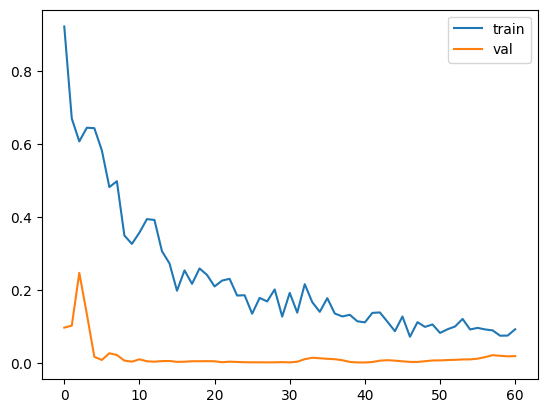

4/4 [==============================] - 0s 2ms/step
train mae: 1.778515202426607
val mae: 2.509017151794433
train smape: 11.520567946598389
val smape: 15.619589454136356
train forecast bias: 7.206259562898023
val forecast bias: 16.920856435656628


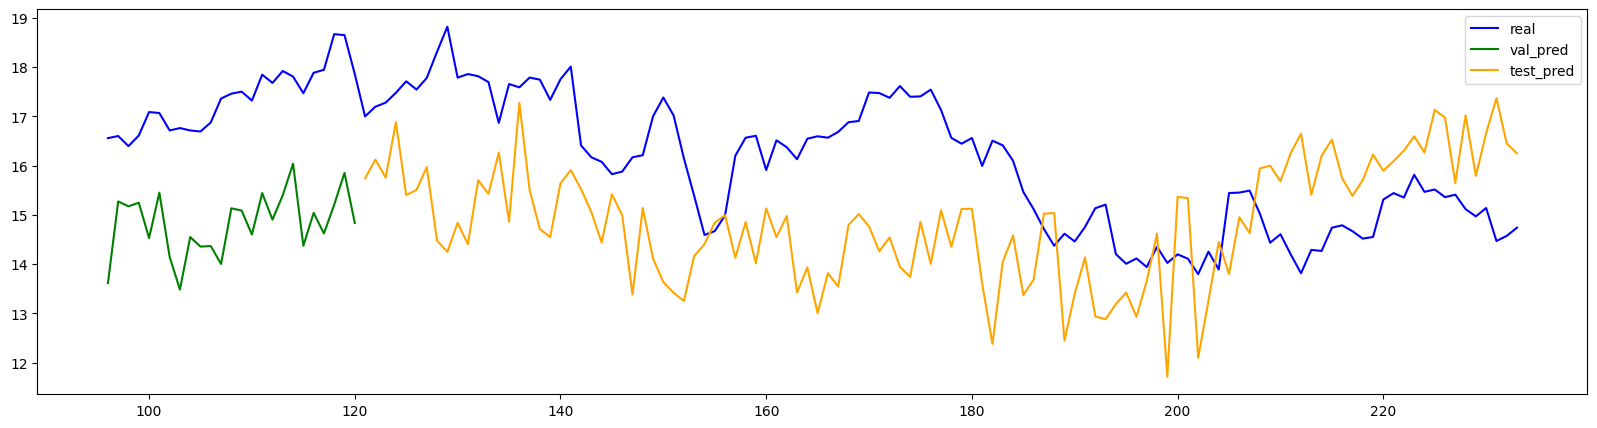

Epoch 1/1000
6/6 [==============================] - 1s 27ms/step - loss: 0.2696 - val_loss: 0.0403
Epoch 2/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2872 - val_loss: 0.0116
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1986 - val_loss: 0.0037
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.2184 - val_loss: 0.0133
Epoch 5/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1586 - val_loss: 0.0055
Epoch 6/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1444 - val_loss: 0.0026
Epoch 7/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1216 - val_loss: 0.0086
Epoch 8/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1221 - val_loss: 0.0199
Epoch 9/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1169 - val_loss: 0.0061
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0961 - val_loss: 0.0031
Epoch 11/1000


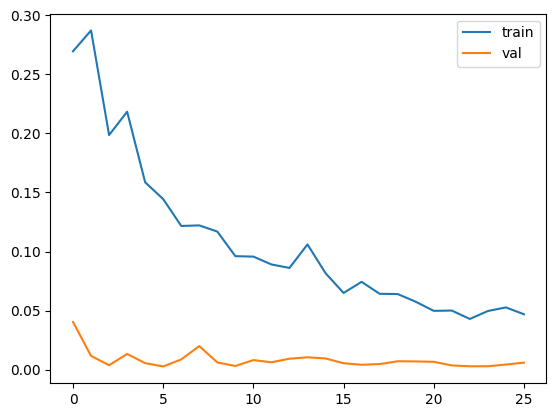

4/4 [==============================] - 0s 4ms/step
train mae: 1.1247256736660847
val mae: 1.2702597187201319
train smape: 8.109576845717555
val smape: 9.062662867982267
train forecast bias: 1.628187093746957
val forecast bias: 8.569336919499827


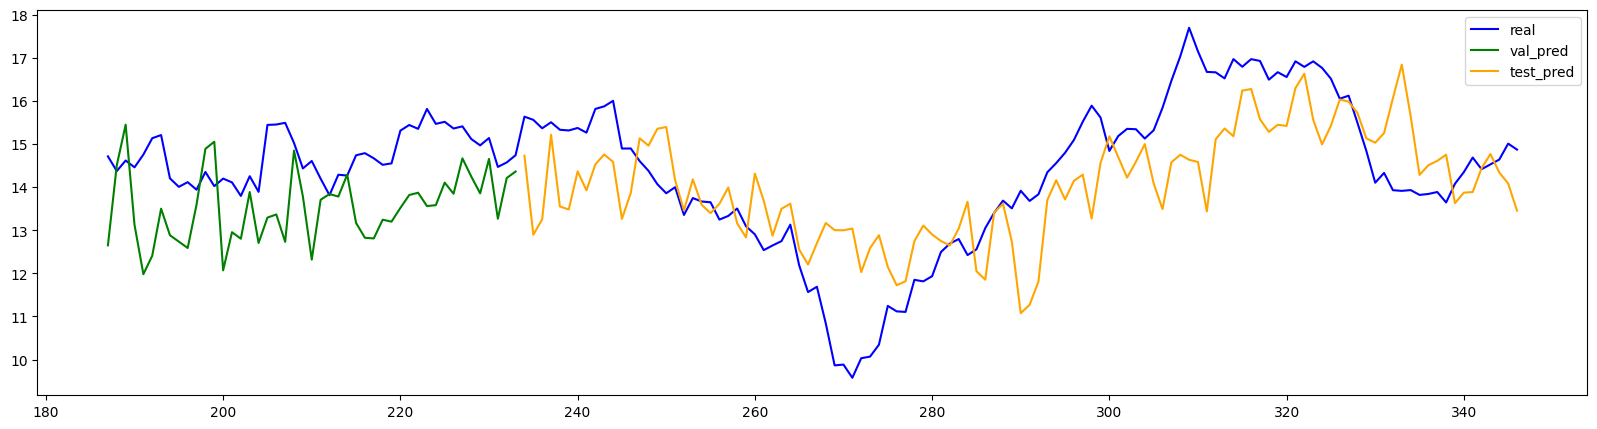

Epoch 1/1000
9/9 [==============================] - 1s 16ms/step - loss: 0.3800 - val_loss: 0.0158
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.3513 - val_loss: 0.0402
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.2576 - val_loss: 0.0105
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.3175 - val_loss: 0.0115
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.2371 - val_loss: 0.0240
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.2032 - val_loss: 0.0273
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1819 - val_loss: 0.0048
Epoch 8/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1718 - val_loss: 0.0058
Epoch 9/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1566 - val_loss: 0.0147
Epoch 10/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1302 - val_loss: 0.0069
Epoch 11/1000
9/9 

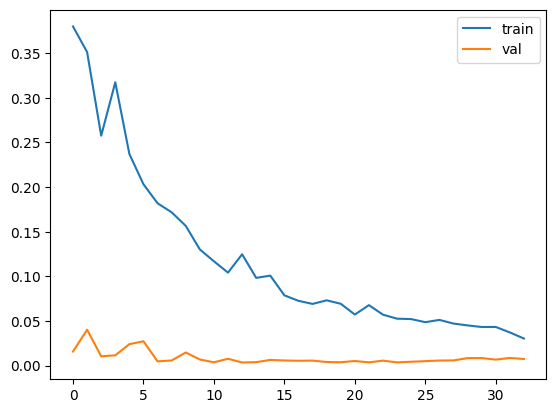

4/4 [==============================] - 0s 2ms/step
train mae: 1.6802699935340546
val mae: 1.3380306732779363
train smape: 12.743696213422467
val smape: 9.264198582995057
train forecast bias: 13.045186242686102
val forecast bias: 8.570343115726818


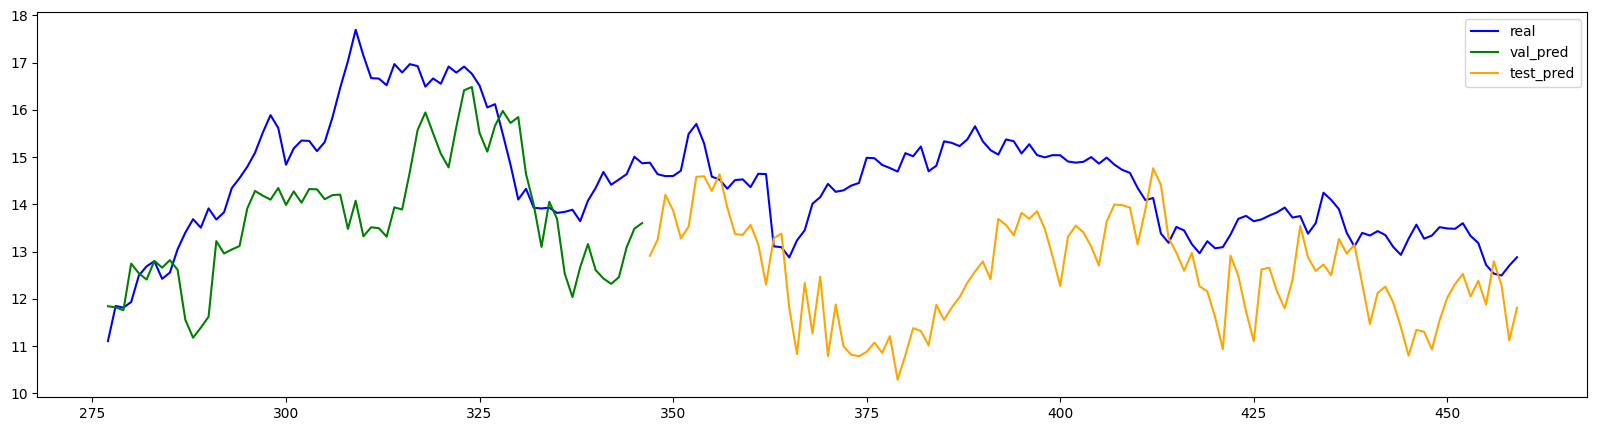

Epoch 1/1000
12/12 [==============================] - 1s 15ms/step - loss: 0.4610 - val_loss: 0.0332
Epoch 2/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.3999 - val_loss: 0.0560
Epoch 3/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.2668 - val_loss: 0.0220
Epoch 4/1000
12/12 [==============================] - 0s 7ms/step - loss: 0.2417 - val_loss: 0.0297
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.1987 - val_loss: 0.0260
Epoch 6/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.1801 - val_loss: 0.0190
Epoch 7/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.1523 - val_loss: 0.0086
Epoch 8/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.1576 - val_loss: 0.0139
Epoch 9/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.1247 - val_loss: 0.0130
Epoch 10/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.1171 - val_loss: 0.011

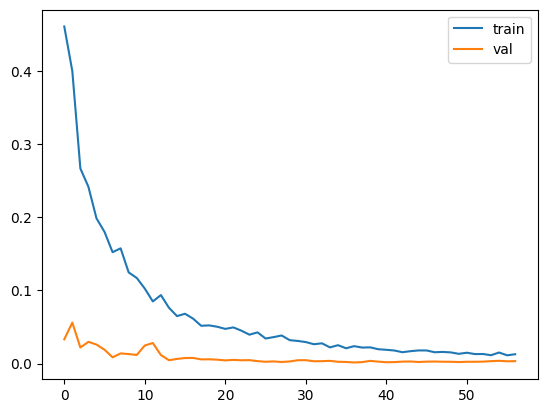

4/4 [==============================] - 0s 2ms/step
train mae: 1.8782613074783732
val mae: 0.9411924107473623
train smape: 11.656210007525608
val smape: 6.762980454815113
train forecast bias: 10.910361974264108
val forecast bias: 6.406702788106308


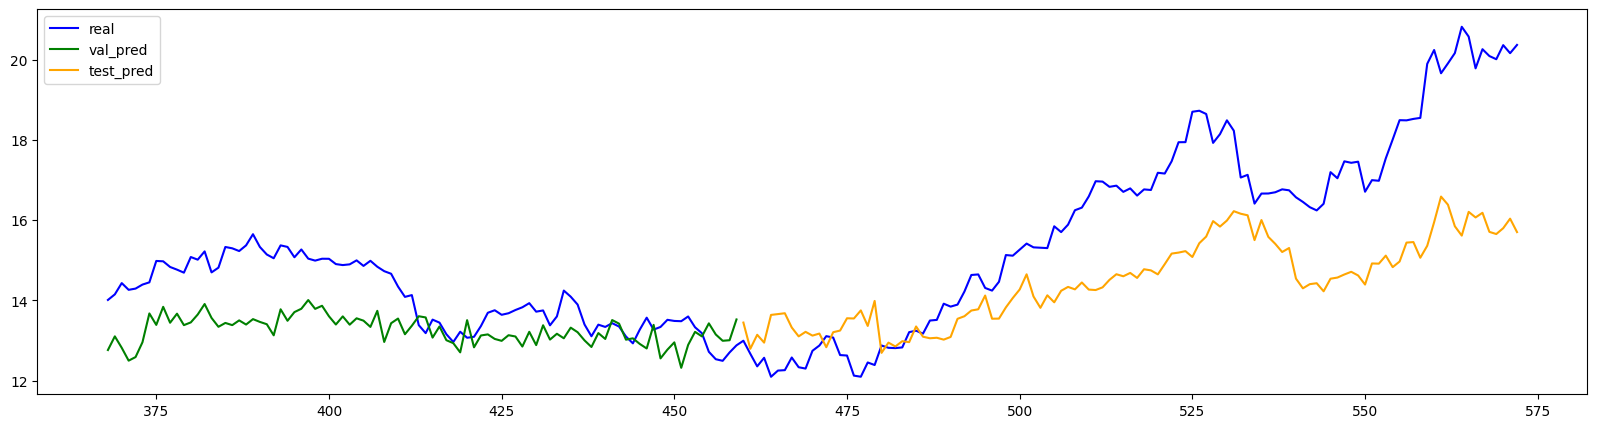

Epoch 1/1000
15/15 [==============================] - 1s 11ms/step - loss: 0.7723 - val_loss: 0.0116
Epoch 2/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.4459 - val_loss: 0.1320
Epoch 3/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.3247 - val_loss: 0.0495
Epoch 4/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.3523 - val_loss: 0.0395
Epoch 5/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.2600 - val_loss: 0.0271
Epoch 6/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.2141 - val_loss: 0.0371
Epoch 7/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.1895 - val_loss: 0.0240
Epoch 8/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.1767 - val_loss: 0.0202
Epoch 9/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.1691 - val_loss: 0.0137
Epoch 10/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1468 - val_loss: 0.02

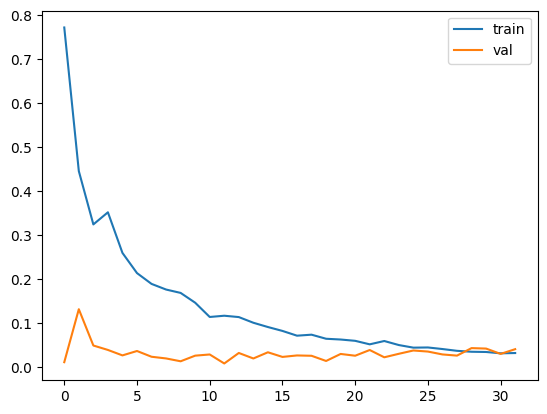

4/4 [==============================] - 0s 2ms/step
train mae: 8.08609964512972
val mae: 3.481829585449749
train smape: 42.82562288540074
val smape: 23.52495124805929
train forecast bias: 54.81309647008985
val forecast bias: 27.82976203681728


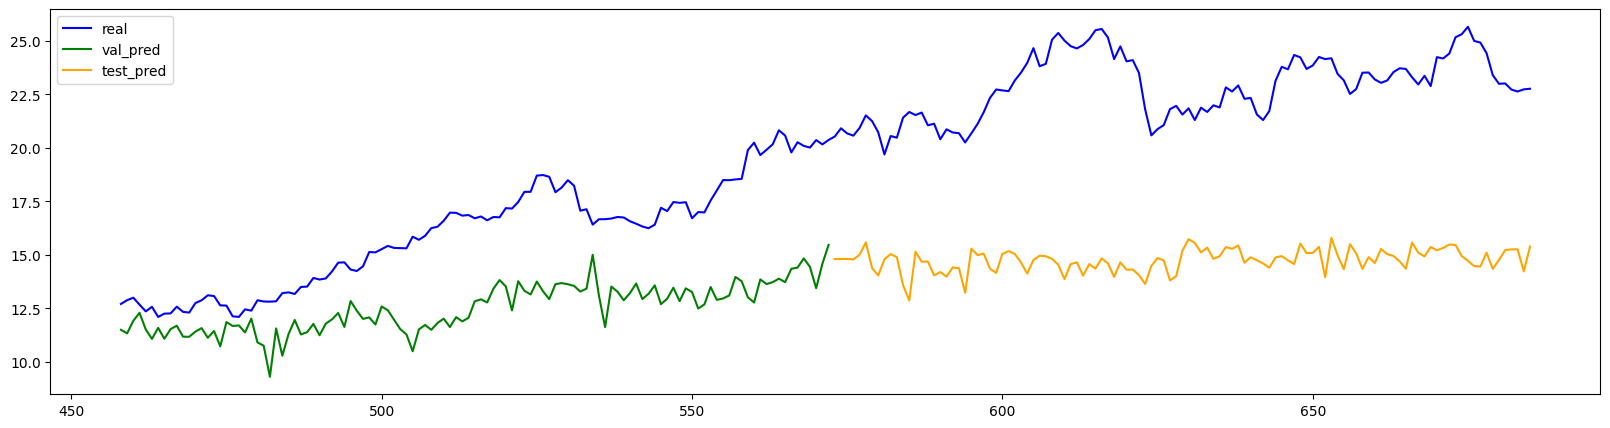

Epoch 1/1000
18/18 [==============================] - 1s 10ms/step - loss: 0.5986 - val_loss: 0.4486
Epoch 2/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.5406 - val_loss: 0.0525
Epoch 3/1000
18/18 [==============================] - 0s 7ms/step - loss: 0.4382 - val_loss: 0.0124
Epoch 4/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.3268 - val_loss: 0.1907
Epoch 5/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.2867 - val_loss: 0.0426
Epoch 6/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.2012 - val_loss: 0.0689
Epoch 7/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.2134 - val_loss: 0.0628
Epoch 8/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.1710 - val_loss: 0.0499
Epoch 9/1000
18/18 [==============================] - 0s 6ms/step - loss: 0.1679 - val_loss: 0.0875
Epoch 10/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.1371 - val_loss: 0.107

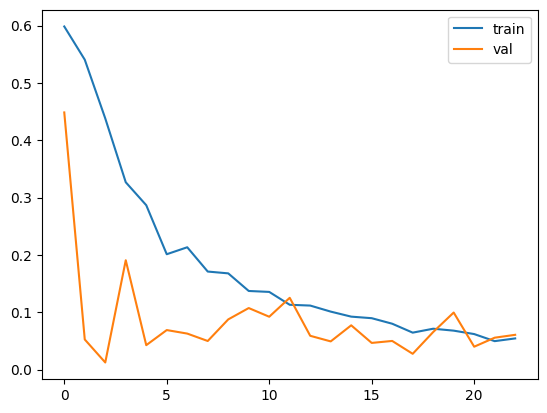

4/4 [==============================] - 0s 2ms/step
train mae: 4.4197603433108705
val mae: 4.538671283436208
train smape: 22.530098441134268
val smape: 22.8521167093396
train forecast bias: 25.08316247219187
val forecast bias: 25.750598171638742


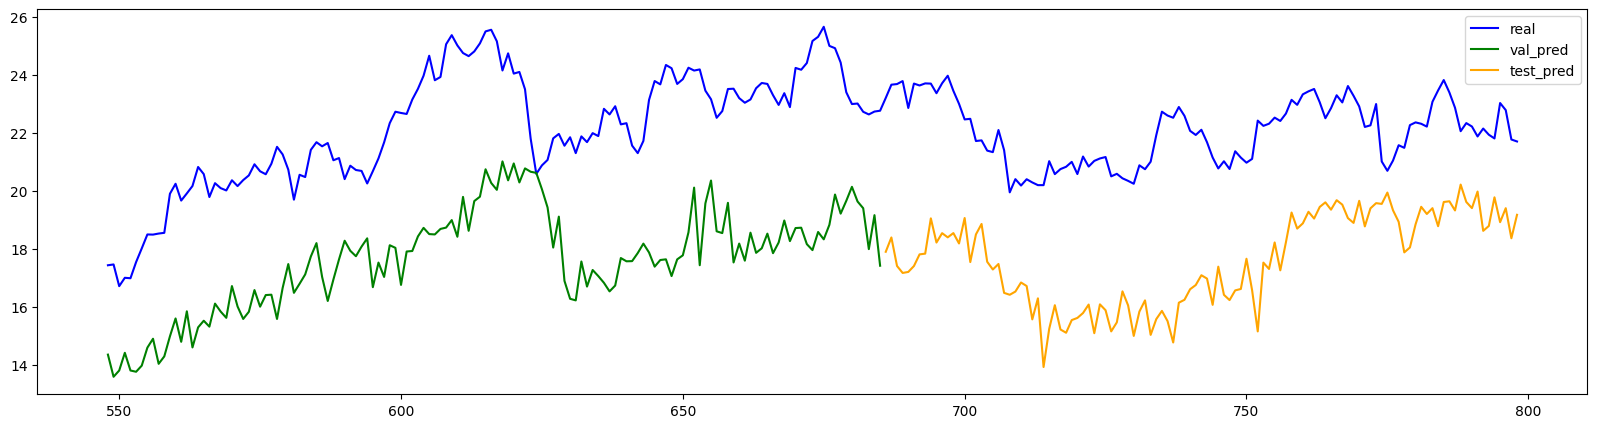

Epoch 1/1000
20/20 [==============================] - 1s 9ms/step - loss: 0.7339 - val_loss: 0.0567
Epoch 2/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.4440 - val_loss: 0.2572
Epoch 3/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3566 - val_loss: 0.0269
Epoch 4/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.2762 - val_loss: 0.0108
Epoch 5/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.2361 - val_loss: 0.0170
Epoch 6/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.1965 - val_loss: 0.0187
Epoch 7/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.1509 - val_loss: 0.0089
Epoch 8/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.1395 - val_loss: 0.0119
Epoch 9/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.1230 - val_loss: 0.0115
Epoch 10/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.1179 - val_loss: 0.0178

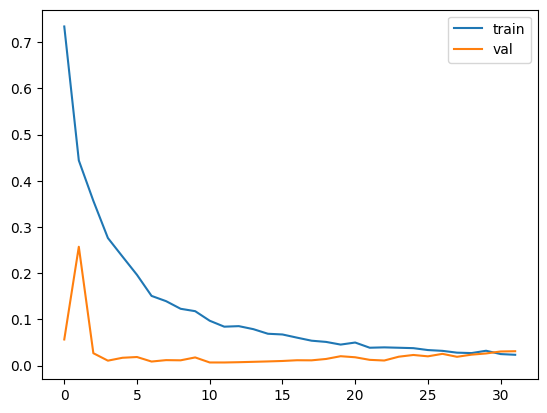

4/4 [==============================] - 0s 2ms/step
train mae: 1.255720316892371
val mae: 3.1480228844352722
train smape: 5.987728391315547
val smape: 15.104754059879358
train forecast bias: -3.0497752763322583
val forecast bias: 16.271736784249082


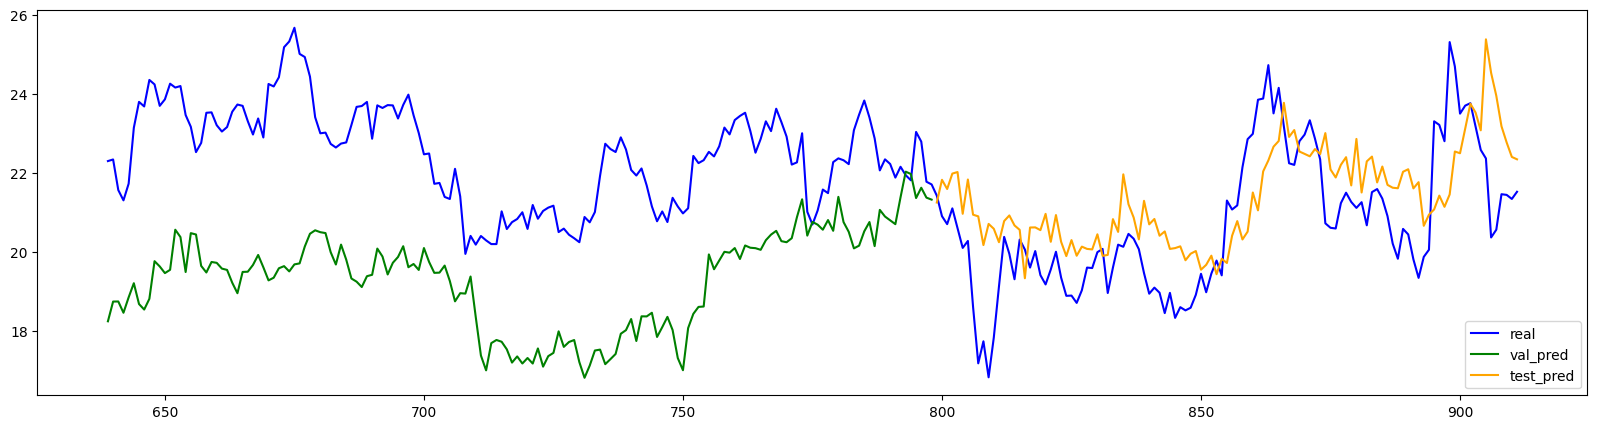

Epoch 1/1000
23/23 [==============================] - 1s 9ms/step - loss: 0.4085 - val_loss: 0.0355
Epoch 2/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.2700 - val_loss: 0.0175
Epoch 3/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.2080 - val_loss: 0.0159
Epoch 4/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.2015 - val_loss: 0.0676
Epoch 5/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.2003 - val_loss: 0.0161
Epoch 6/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.1503 - val_loss: 0.0147
Epoch 7/1000
23/23 [==============================] - 0s 7ms/step - loss: 0.1144 - val_loss: 0.0246
Epoch 8/1000
23/23 [==============================] - 0s 6ms/step - loss: 0.0803 - val_loss: 0.0097
Epoch 9/1000
23/23 [==============================] - 0s 5ms/step - loss: 0.0783 - val_loss: 0.0322
Epoch 10/1000
23/23 [==============================] - 0s 6ms/step - loss: 0.0615 - val_loss: 0.0148

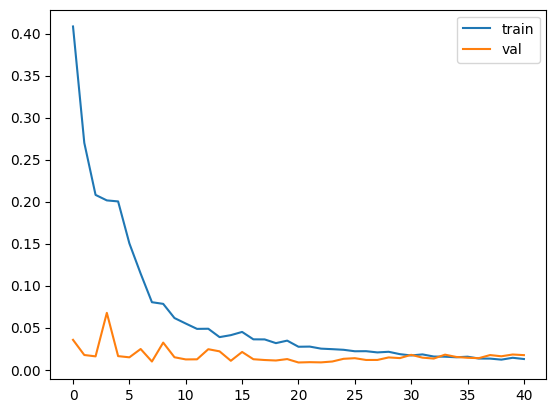

4/4 [==============================] - 0s 2ms/step
train mae: 1.481736086734738
val mae: 2.036871201198557
train smape: 7.109587471846601
val smape: 9.915246000772877
train forecast bias: 1.5747733463489948
val forecast bias: 9.474617546673654


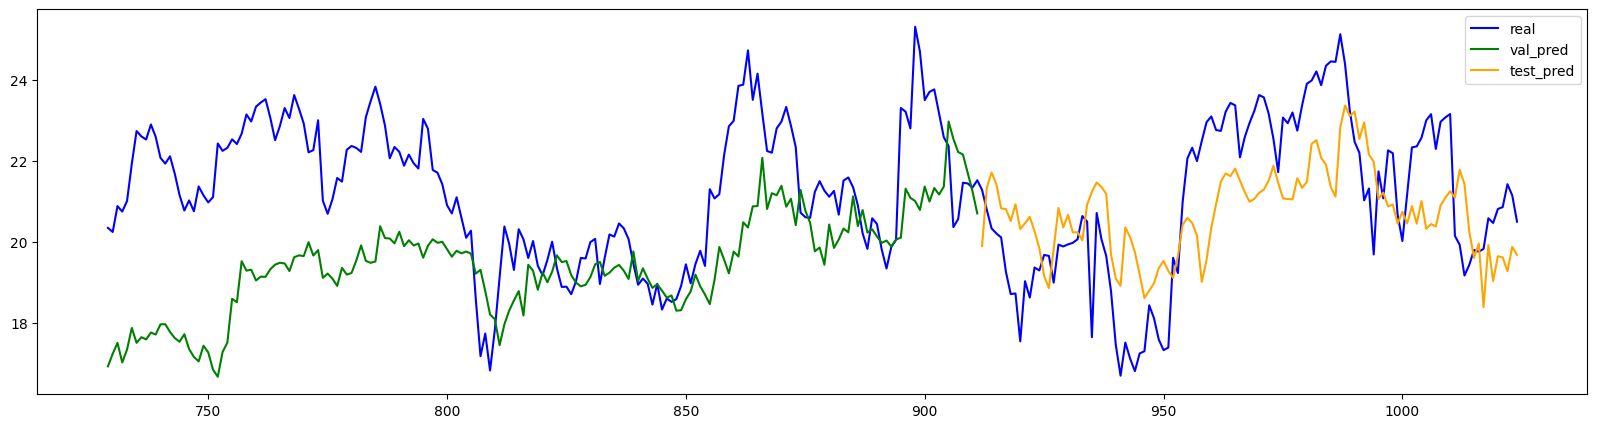

Epoch 1/1000
26/26 [==============================] - 1s 7ms/step - loss: 0.5185 - val_loss: 0.4582
Epoch 2/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.3222 - val_loss: 0.2700
Epoch 3/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.2559 - val_loss: 0.0699
Epoch 4/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.2354 - val_loss: 0.0512
Epoch 5/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.2026 - val_loss: 0.0135
Epoch 6/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.2034 - val_loss: 0.0203
Epoch 7/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1682 - val_loss: 0.0088
Epoch 8/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.1206 - val_loss: 0.0081
Epoch 9/1000
26/26 [==============================] - 0s 5ms/step - loss: 0.0987 - val_loss: 0.0280
Epoch 10/1000
26/26 [==============================] - 0s 4ms/step - loss: 0.0733 - val_loss: 0.0077

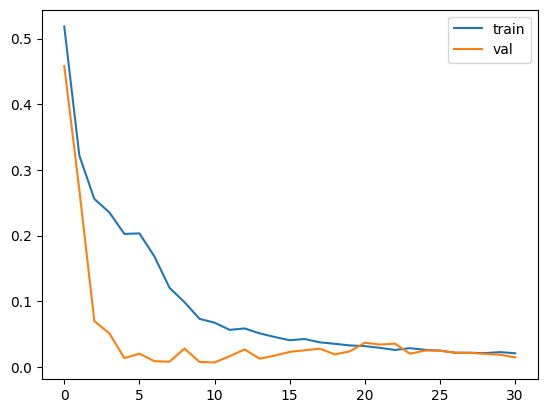

4/4 [==============================] - 0s 3ms/step
train mae: 0.896270497161055
val mae: 1.942331842433427
train smape: 5.443181770676391
val smape: 9.589999239710897
train forecast bias: -0.8921170151062282
val forecast bias: 8.915685230824629


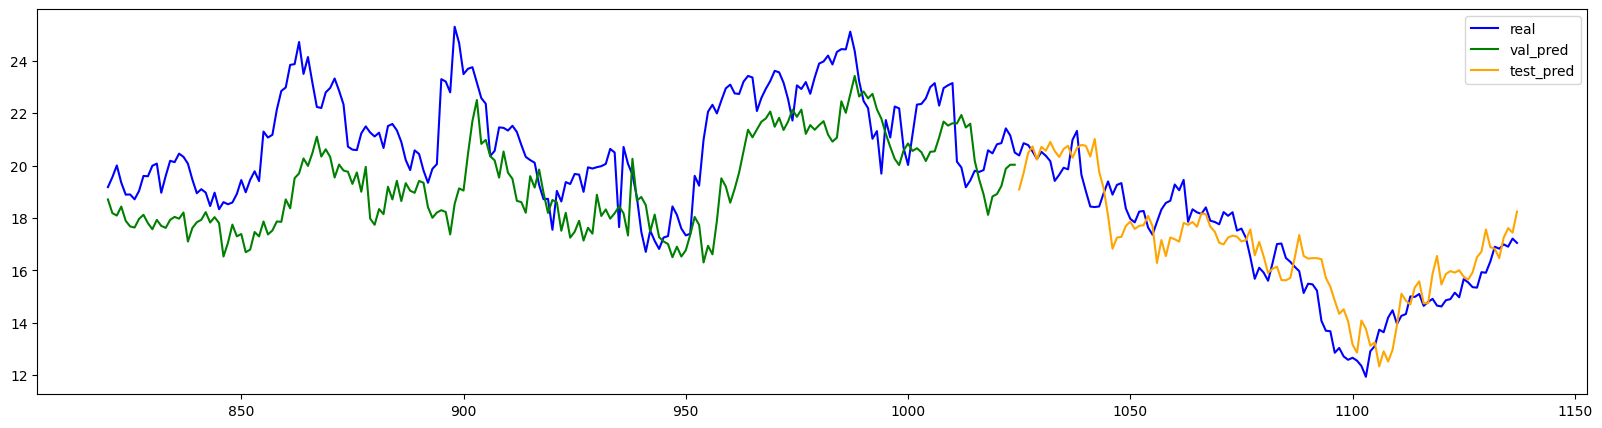

Epoch 1/1000
29/29 [==============================] - 1s 8ms/step - loss: 0.3417 - val_loss: 0.0222
Epoch 2/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.2493 - val_loss: 0.0562
Epoch 3/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.2053 - val_loss: 0.4100
Epoch 4/1000
29/29 [==============================] - 0s 7ms/step - loss: 0.1655 - val_loss: 0.0536
Epoch 5/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.2117 - val_loss: 0.0239
Epoch 6/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.1436 - val_loss: 0.0339
Epoch 7/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.1245 - val_loss: 0.0223
Epoch 8/1000
29/29 [==============================] - 0s 6ms/step - loss: 0.0606 - val_loss: 0.0180
Epoch 9/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.0508 - val_loss: 0.0158
Epoch 10/1000
29/29 [==============================] - 0s 5ms/step - loss: 0.0462 - val_loss: 0.0156

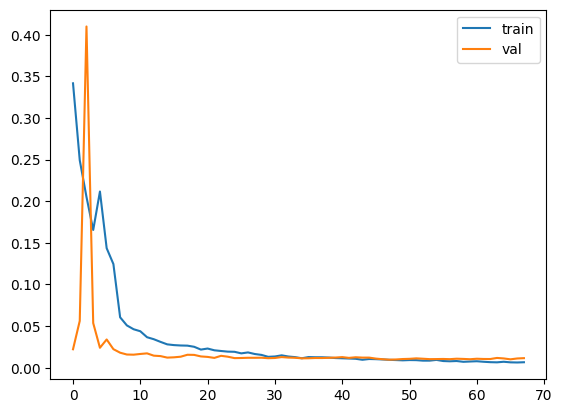

4/4 [==============================] - 0s 3ms/step
train mae: 2.3743610559038824
val mae: 1.7042287809622245
train smape: 12.585225121736324
val smape: 9.292268932181697
train forecast bias: -2.8152189395268334
val forecast bias: -1.2160204500796727


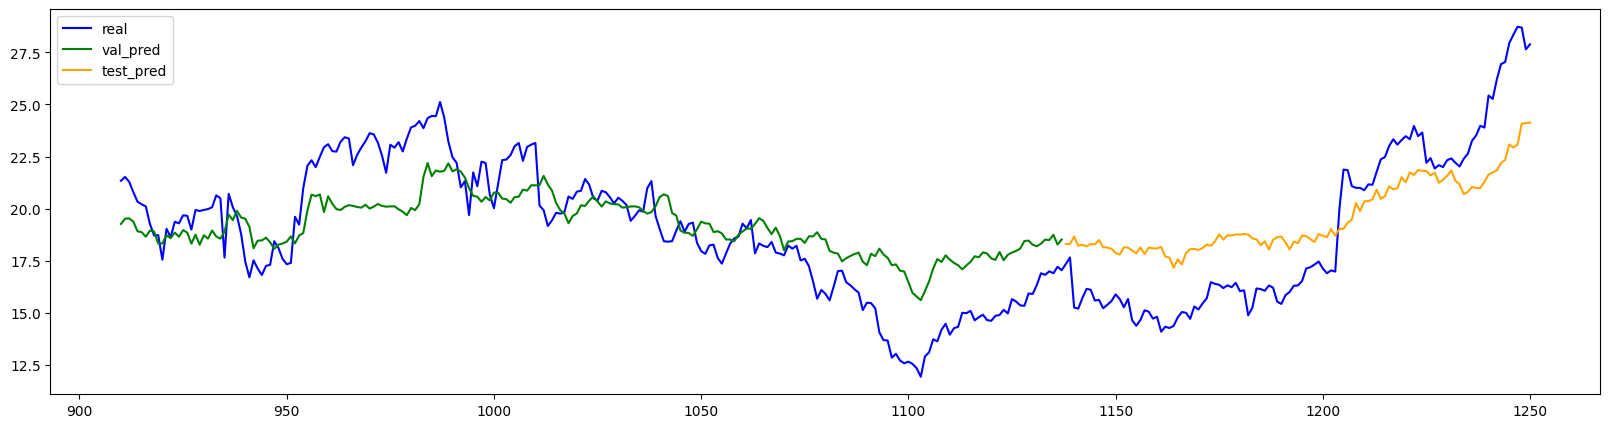

In [48]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
t_smapes=[]
v_smapes=[]
t_forecast_biases=[]
v_forecast_biases=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=mae(pred,y_test)
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=mae(val_pred,y_val)
    v_maes.append(v_mae)
    print('val mae:',v_mae)
    t_smape=smape(pred,y_test)
    t_smapes.append(t_smape)
    print('train smape:',t_smape)
    v_smape=smape(val_pred,y_val)
    v_smapes.append(v_smape)
    print('val smape:',v_smape)
    t_forecast_bias=forecast_bias(pred,y_test)
    t_forecast_biases.append(t_forecast_bias)
    print('train forecast bias:',t_forecast_bias)
    v_forecast_bias=forecast_bias(val_pred,y_val)
    v_forecast_biases.append(v_forecast_bias)
    print('val forecast bias:',v_forecast_bias)
    

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [49]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_19 (TCN)                (None, 128)               259456    
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 259585 (1014.00 KB)
Trainable params: 259585 (1014.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Taverage_smape=np.mean(t_smapes)

print('Average SMAPE in testing:',Taverage_smape)

Vaverage_smape=np.mean(v_smapes)

print('Average SMAPE in validation:',Vaverage_smape)


Taverage_forecast_bias=np.mean(t_forecast_biases)

print('Average forecast bias in testing:',Taverage_forecast_bias)

Vaverage_forecast_bias=np.mean(v_forecast_biases)

print('Average forecast bias in validation:',Vaverage_forecast_bias)

Average MAE in testing: 2.4975720122237757
Average MAE in validation: 2.2910455532455303
Average SMAPE in testing: 14.051149509537387
Average SMAPE in validation: 13.09887675498725
Average forecast bias in testing: 10.750391593126059
Average forecast bias in validation: 12.74936185791133
